# Exploratory Data Analysis en el mercado cripto.

In [183]:
# import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
# from matplotlib.ticker import MultipleLocator,MaxNLocator,FormatStrFormatter,StrMethodFormatter
from matplotlib.dates import YearLocator,DateFormatter

In [46]:
sns.set()
%matplotlib inline
sns.set(rc={"figure.figsize": (17.75,9)}) # Tamaño de las figuras
%config Completer.use_jedi = False # Autocompletar más rápido
pd.options.display.float_format = "{:.2f}".format # Mostrar solo dos decimales en pandas
sns.set_style('whitegrid')

### Estructura de los datasets

Primero veamos, en las 2 celdas siguientes, los datos por separado de ambas fuentes para conocer su estructura y entender mejor cómo trabajar con ellos.

In [428]:
cg_btc = pd.read_csv('CoinGecko/data/btc.csv')
cg_btc['Fecha'] = pd.to_datetime(cg_btc.Fecha)
cg_btc['BTC_Volumen'] = cg_btc.Volumen / cg_btc.Precios
# cg_btc = cg_btc[['Fecha','Market_Cap','Volumen','BTC_Volumen']]
cg_btc.columns = ['Fecha','Precios','Market_Cap','USD_Volumen','BTC_Volumen']

bn_btc = pd.read_csv('Binance/data/by1d/btcusdt.csv')
bn_btc['Fecha'] = pd.to_datetime(bn_btc.Fecha)

bn_btc.head(1)

,Fecha,Abre,Alto,Bajo,Cierra,BTC_Volumen,USDT_Volumen
0,2017-08-17,4261.48,4485.39,4200.74,4285.08,795.15,3454770.05


In [429]:
cg_btc.head(1)

,Fecha,Precios,Market_Cap,USD_Volumen,BTC_Volumen
0,2013-04-30,135.30,1501657493.00,0.00,0.00


# Inconsistencias con los datos de volumen?

Lo que sucede es que coingecko rastrea el volúmen de transacción en, a la fecha de hoy, 821 intercambios a nivel mundial. De todos esos intercambios, rastrea todo el volumen de bitcoin a través de todos los pares de cada intercambio.

Es debido a ello que la cantidad en volumen difiera con la de binance, ya que binance solo nos entrega el volumen que ellos procesan, además, no estamos contabilizando el volumen total a través de todos los pares de binance, sino solo a través del par BTCUSDT. Si deseamos algo más acercado a la realidad del exchange binance y su participación total relativa al volumen total de btc en los 821 intercambios de coingecko, deberíamos sumar el volumen de btc de cada par listado en binance.

Para las diferencias con el volumen solo hace falta ver los datos de una sola cripto.

Veamos las conclusiones a continuación con el siguiente dataframe.

In [450]:
df = bn_btc[['Fecha','Cierra','BTC_Volumen','USDT_Volumen']]
df.columns = ['Fecha','Precios','BTC_Volumen','USDT_Volumen']
df = df.merge(cg_btc,suffixes=('_bn','_cg'),how='left',on='Fecha')
df.head(5)

,Fecha,Precios_bn,BTC_Volumen_bn,USDT_Volumen,Precios_cg,Market_Cap,USD_Volumen,BTC_Volumen_cg
0,2017-08-17,4285.08,795.15,3454770.05,4286.92,70778773053.66,1774245121.03,413874.34
1,2017-08-18,4108.37,1199.89,5086958.31,4097.69,67671539511.39,1515069151.86,369737.76
2,2017-08-19,4139.98,381.31,1549483.74,4115.21,67968693045.18,1710080500.02,415551.01
3,2017-08-20,4086.29,467.08,1930364.39,4001.23,66092742688.79,551798951.97,137907.38
4,2017-08-21,4016.00,691.74,2797231.71,3935.23,65008176478.94,712634899.40,181091.04


En el dataframe anterior vemos cómo difieren las cantidades entre USD_Volumen y USDT_Volumen

# Inconsistencias con los datos de precios?

Debido a que CoinGecko no es un exchange, no podemos fiarnos de sus precios para hacer transacciones, por lo que, en primera instancia, un análisis apropiado se debería de realizar con los datos con los que se van a trabajar en realidad, sin embargo, para propósitos de calidad en nuestro análisis, vamos a ver qué tan diferentes son los datos de precios entre CoinGecko y un intercambio como Binance. En la página de CoinGecko ya nos dicen que sus precios están calculados con base en una ecuación dada por ellos. Aquí solo vamos a verificar dicha diferencia y a cuantificarla.

Aquí debemos analizar la totalidad de las criptos que estamos trabajando.

In [482]:
# Lo que se hace aquí es cargar todos los datos en DF's, para después hacer un .merge() de todos ellos, tanto los de binance como los de coingecko. Se realizan algunas transformaciones.
dfc = []
crl = []
for i in [i for i in os.listdir('CoinGecko/data') if '_' not in i]:
    path = f'CoinGecko/data/{i}'
    crl.append(i.replace('.csv',''))
    dfc.append(pd.read_csv(path))
    if crl[-1] == 'btc':
        dfc = [dfc.pop()] + dfc
        crl = [crl.pop()] + crl

j = 0
for i in dfc:
    i['Fecha'] = pd.to_datetime(i.Fecha)
    i = i[['Fecha','Precios']]
    i.columns = ['Fecha',f'{crl[j].upper()}']
    if j == 0:
        df_cg = i
    else:
        df_cg = df_cg.merge(i,how='left',on='Fecha')
    j += 1
    
dfx = pd.melt(df_cg,id_vars='Fecha',value_vars=list(df_cg.columns).remove('Fecha'),var_name='Criptos')

dfb = []
for i in [i for i in os.listdir('Binance/data/by1d/') if '_' not in i]:
    path = f'Binance/data/by1d/{i}'
    dfb.append(pd.read_csv(path))
    if i.replace('usdt.csv','') == 'btc':
        dfb = [dfb.pop()] + dfb
    
j = 0
for i in dfb:
    i['Fecha'] = pd.to_datetime(i.Fecha)
    i = i[['Fecha','Cierra']]
    i.columns = ['Fecha',f'{crl[j].upper()}']
    if j == 0:
        df_bn = i
    else:
        df_bn = df_bn.merge(i,how='left',on='Fecha')
    j += 1
    
dfy = pd.melt(df_bn,id_vars='Fecha',value_vars=list(df_bn.columns).remove('Fecha'),var_name='Criptos')

comparativa_precios = dfx.merge(dfy,on=['Fecha','Criptos']).rename(columns={'value_x':'Precio_cg','value_y':'Precio_bn'})
comparativa_precios['Diferencia'] = abs(comparativa_precios['Precio_cg'] - comparativa_precios['Precio_bn'])

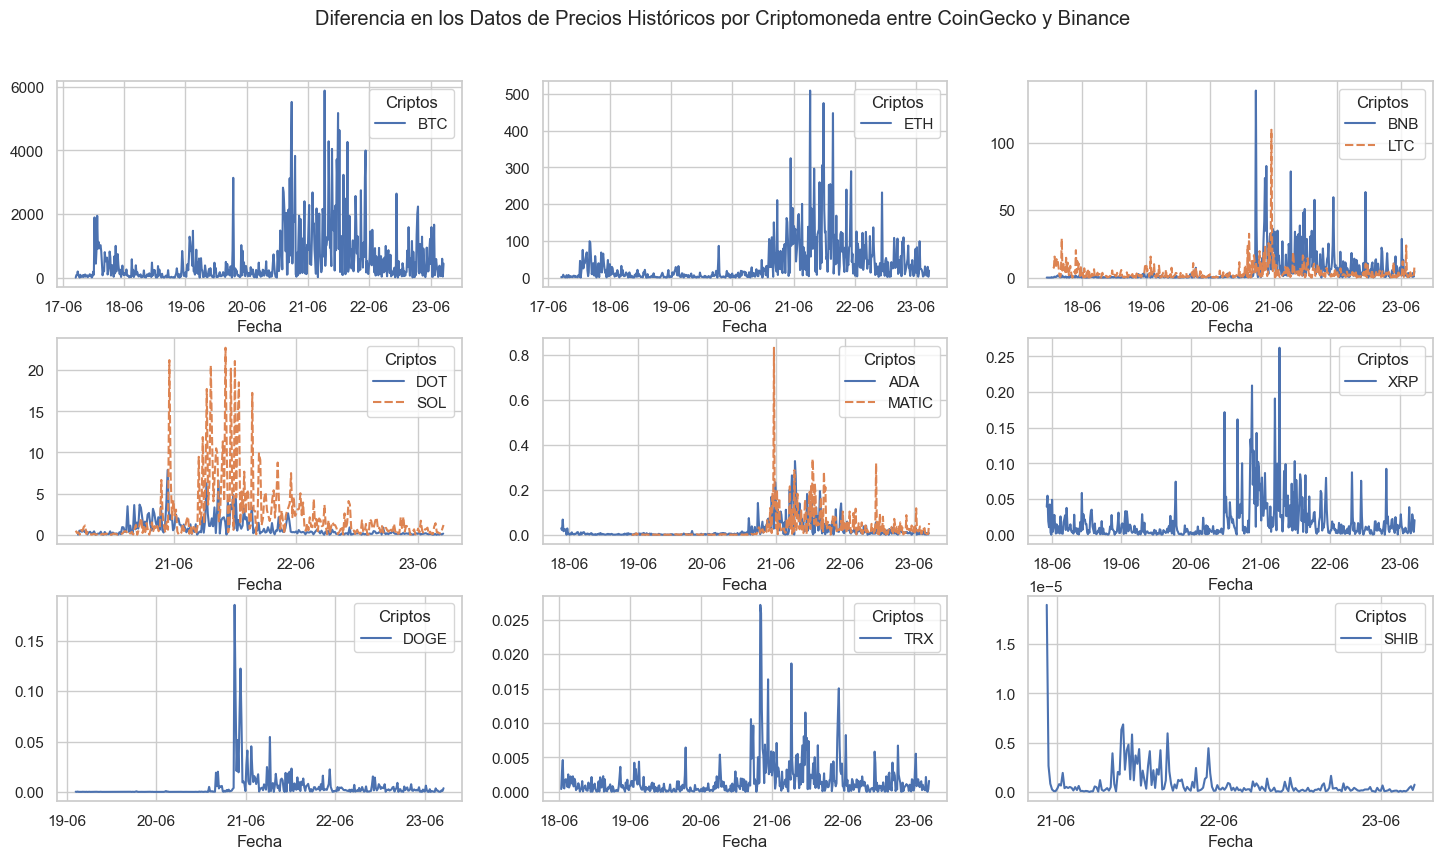

In [483]:
fig = plt.figure()
plt.subplots_adjust(left=0.125,
                    bottom=0.1, 
                    right=0.9, 
                    top=0.9, 
                    wspace=0.2, 
                    hspace=0.25)
fig.suptitle('Diferencia en los Datos de Precios Históricos por Criptomoneda entre CoinGecko y Binance')

lista = []
plots = ['BTC','ETH',['BNB','LTC'],['SOL','DOT'],['MATIC','ADA'],'XRP','DOGE','TRX','SHIB']
for i in range(1,10):
    lista.append(fig.add_subplot(330+i))
    
for ax in lista:
    ax.xaxis.set_major_locator(YearLocator(1, month=6, day=1))
    ax.xaxis.set_major_formatter(DateFormatter('%y-%m'))

j = 0
for i in plots:
    if type(i) == str:
        sns.lineplot(comparativa_precios[comparativa_precios.Criptos == i][::4].groupby(['Fecha','Criptos'])['Diferencia'].first().unstack(),ax=lista[j])
    elif type(i) == list:
        sns.lineplot(comparativa_precios[comparativa_precios.Criptos.isin(i)][::4].groupby(['Fecha','Criptos'])['Diferencia'].first().unstack(),ax=lista[j])
    j += 1

### Primera conclusión.

Podemos concluir que, para un análisis más acertado, tenemos los siguientes puntos:

    * Debido a que coingecko no es un exchange, debemos utilizar los precios del exchange en el que se quiera operar, ya que es ahí donde haremos la operación, no en coingecko. Además, en las gráficas anteriores, vemos que para las principales criptomonedas (BTC, ETH, BNB, LTC, SOL, DOT) existe una diferencia de precio significativa entre CoinGecko y el intercambio en cuestión.

    * Sería más apropiado agregar a nuestro análisis, al menos los principales exchanges para verificar diferencias de precios entre los mismos. Incluso esta estrategia podría identificar diferencias de precios lo suficientemente buenas como para hacer trading entre exchanges mediante transferencias de XRP, aunque esto último son casos excepcionales. En un sentido más técnico, las variaciones de precio entre exchanges, así como sus variaciones en volumen, podrían aportar datos relevantes por medio de un análisis de IA. 
    
    Además, la visualización de la celda anterior podría marcarnos la pauta de cuándo verificar datos de diferentes intercambios. Esto es así porque, si existe mucha diferencia entre el precio de un intercambio y el precio de coingecko, significaría, bajo nuestras conclusiones, que en otros intercambios el precio tendría un precio distinto. Sin embargo, esto último debemos verificarlo con datos de otros intercambios, esta verificación nos diría si la variación entre precios en intercambios es lo suficiente como para que sea una estrategia rentable el trading entre intercambios (entendiendo "trading entre intercambios"a la acción de hacer trading entre la cripto elegida y XRP para trasferir dichos activos entre intercambios para comprar la cripto elegida, pero más barata, siendo el beneficio de aumentar la tenencia en cripto pero sin aumentar el capital).

    * Considerando los dos puntos anteriores, se concluye que es una buena combinación utilizar el precio del exchange para un determinado par, como BTCUSDT, pero el volumen general indicado por coingecko. Ya que si bien el precio del exchange es el importante para las operaciones, el valor del volumen total nos da más información sobre tendencias del mercado en general, y como sabemos que es el mercado en general el que mueve el precio de BTC y no solo el mercado interno de binance, tiene sentido utilizar el volumen del mercado para obtener más información en vez de limitarse a la información de un solo exchange.

Al respecto de lo último, no sé si la combinación del volumen de binance junto con el general, aporte algo de valor en el análisis, por lo que dejaremos de lado los datos de volumen de binance. Así como también dejaremos de lado agregar datos de otros intercambios, nos limitaremos a coingecko y binance en lo que podamos hacer coincidir sus datos.

También vamos a prescindir de la columna de Precios_cg, ya que solo nos sirvió para verificar que solo es un valor de referencia y no de trabajo.

### Integrando todas las criptos a trabajar

En la siguiente sección vamos a utilizar nuestro desarrollo de la celda de código anterior para generar las nuevas gráficas que van a darnos una mejor perspectiva de estos simples datos a nivel de todas las criptomonedas juntas.

In [492]:
# Los siguientes ciclos tienen como objetivo la generalización de ciertos procedimientos a todos los DF's almacenados en la lista. Además de unirlos todos mediante merge().
j = 0
for i in dfc:
    i['Fecha'] = pd.to_datetime(i.Fecha)
    i[f'{coins[j]}_Volumen'] = i.Volumen / i.Precios
    i = i[['Fecha','Market_Cap','Volumen',f'{crl[j]}_Volumen']]
    i.columns = ['Fecha',f'Market_Cap_{crl[j].upper()}_cg',f'USD_Volumen_{crl[j].upper()}_cg',f'{crl[j].upper()}_Volumen_cg']
    
    if j == 0:
        df_cg = i
    else:
        df_cg = df_cg.merge(i,how='left',on='Fecha')
    j += 1

j = 0
for i in dfb:
    i['Fecha'] = pd.to_datetime(i.Fecha)
    i = i[['Fecha','Cierra']]
    i.columns = ['Fecha',f'Precio_{crl[j].upper()}_USD_bn']
    
    if j == 0:
        df_bn = i
    else:
        df_bn = df_bn.merge(i,how='left',on='Fecha')
    j += 1
    
# Por último ordeno las columnas por orden alfabético
df_bn = df_bn[sorted(df_bn.columns)]
df_cg = df_cg[sorted(df_cg.columns)]

##### Uso de máscaras para filtrar columnas de nuestro DF.

In [490]:
cols = df_cg.columns
mc_str = [i for i in cols if 'Market_Cap' in i]
usv_str = [i for i in cols if 'USD' in i]
crv_str = [i for i in cols if 'USD' not in i and 'Market_Cap' not in i and 'Fecha' not in i]

cols_cg = []
for i in range(len(mc_str)):
    if i == 0:
        cols_cg.append('Fecha')
    cols_cg.append(crv_str[i]), cols_cg.append(usv_str[i]), cols_cg.append(mc_str[i])
df_cg = df_cg[cols_cg]

### Funcionamiento de los DF.

Vamos a utilizar los dataframes anteriores para generar correlaciones entre parámetros de todas las criptomonedas juntas. Regresaremos a esto más adelante. El tratamiento de los dos DF's anteriores y el de los DF's que estamos por crear es totalmente distinto.

### Uso de la función pd.melt()

Lo que haremos a continuación es un "unpivot" de nuestro dataframe con respecto a los tres parámetros de las 12 criptomonedas que estamos considerando. Esto lo haremos para poder dividir la información en DF's que la contengan, separada por el tipo de parámetro. 

Para separar por el tipo de parámetro, utilizaremos las máscaras creadas unas celdas arriba.

In [ ]:
dfx = pd.melt(df_cg,id_vars='Fecha',value_vars=df_cg.columns.to_list().remove('Fecha'),var_name='Cripto')

crv_df = dfx[dfx['Cripto'].isin(crv_str)].reset_index(drop=True)
usv_df = dfx[dfx['Cripto'].isin(usv_str)].reset_index(drop=True)
mc_df = dfx[dfx['Cripto'].isin(mc_str)].reset_index(drop=True)

for i in sorted(coins):
    crv_df['Tipo'] = crv_df['Tipo'].apply(lambda x: f'{i.upper()}' if i.upper() in x else x)
    usv_df['Tipo'] = usv_df['Tipo'].apply(lambda x: f'{i.upper()}' if i.upper() in x else x)
    mc_df['Tipo'] = mc_df['Tipo'].apply(lambda x: f'{i.upper()}' if i.upper() in x else x)

# Ahora cambiamos de 'Tipo' a 'Cripto' puesto que ya tenemos los DF's separados por los 3 parámetros.
crv_df = crv_df.dropna().reset_index(drop=True)
usv_df = usv_df.dropna().reset_index(drop=True)
mc_df = mc_df.dropna().reset_index(drop=True)


##### Diferencia de fechas iniciales.

Con la siguiente celda de código vemos que CoinGecko comenzó a obtener datos de las diferentes criptomonedas en diferentes fechas. Lo cual tiene sentido puesto que todas comenzaron en fechas distintas.

In [ ]:
crv_df.dropna()['Cripto'].value_counts()

BTC      3763
LTC      3757
XRP      3658
DOGE     3528
ETH      2930
BNB      2160
ADA      2130
TRX      2108
MATIC    1577
SOL      1226
SHIB     1100
DOT      1096
Name: Cripto, dtype: int64

# Orden en las visualizaciones

Vamos primero a visualizar los DF's de parámetros específicos por separado. Posteriormente regresaremos con los 2 DF's que se crearon al inicio: df_cg y df_bn.

### Gráficos históricos de Volumen y Market Cap: Primeras 7 criptomonedas en Capitalización de mercado.

Veamos algunos gráficos de barras descriptivos, relacionados con la capitalización de mercado y el volumen de transacción de estas criptomonedas. Veamos sus mínimos, máximos y promedios.

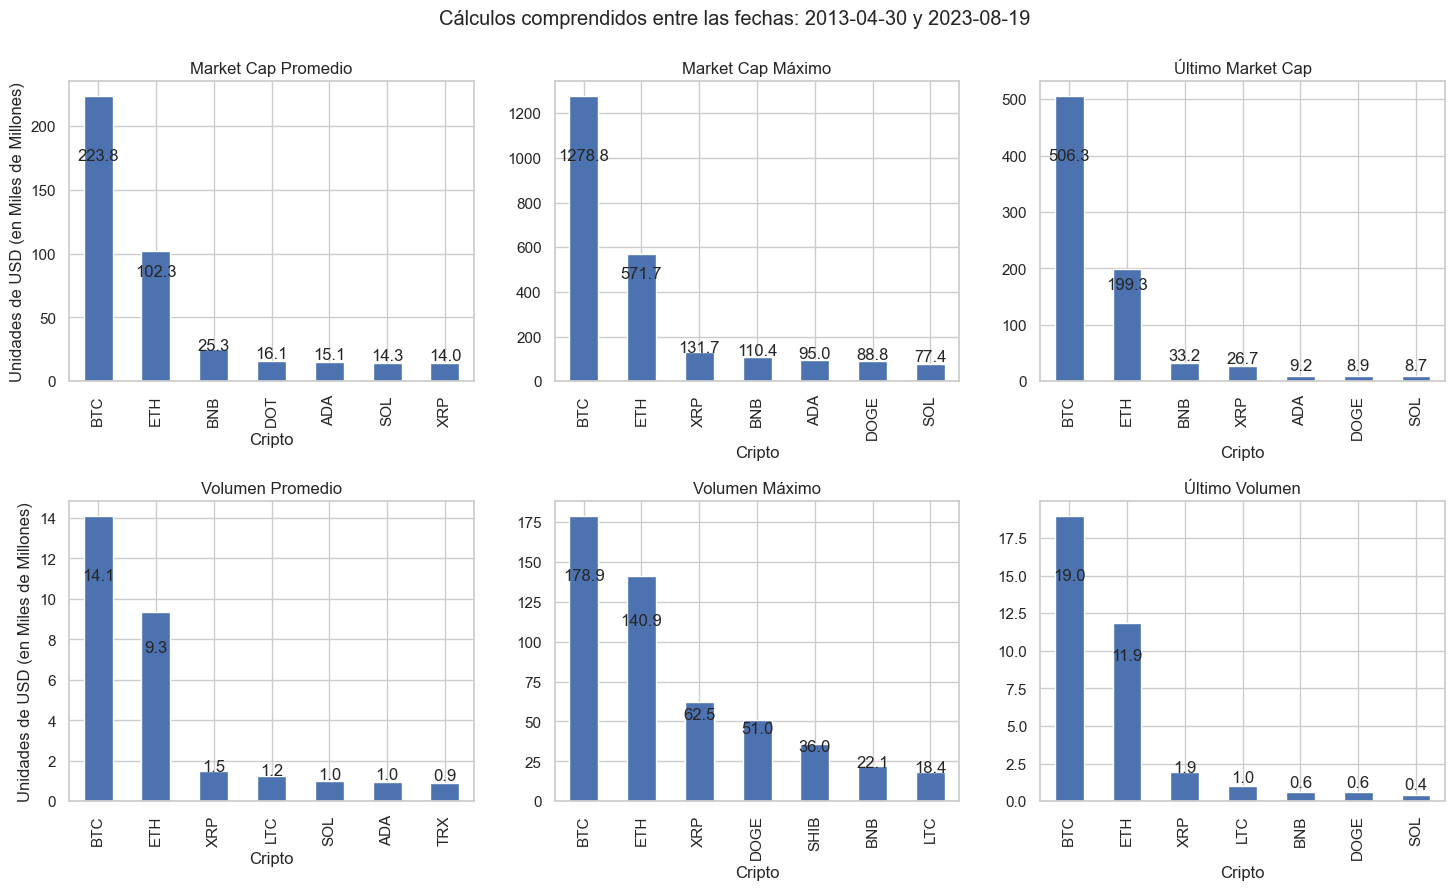

In [ ]:
fig = plt.figure()
fig.suptitle(f'Cálculos comprendidos entre las fechas: {sd} y {ed}')
plt.subplots_adjust(left=0.125,
                    bottom=0.1, 
                    right=0.9, 
                    top=0.9, 
                    wspace=0.2, 
                    hspace=0.4)

axes = []
for i in range(1,7):
    axes.append(fig.add_subplot(230+i))

sd = mc_df.sort_values(by='Fecha').reset_index(drop=True).Fecha[0].strftime('%Y-%m-%d')
ed = mc_df.sort_values(by='Fecha').reset_index(drop=True).Fecha[-1:].item().strftime('%Y-%m-%d')

ax1.set_title(label=f'Market Cap Promedio'), ax1.set_ylabel('Unidades de USD (en Miles de Millones)'), ax2.set_title(label=f'Market Cap Máximo'), ax3.set_title(label=f'Último Market Cap')
ax4.set_title(label=f'Volumen Promedio'), ax4.set_ylabel(ylabel='Unidades de USD (en Miles de Millones)'), ax5.set_title(label=f'Volumen Máximo'), ax6.set_title(label=f'Último Volumen')

mc_df['Market_Cap_mM'] = mc_df.Market_Cap / 1000000000
usv_df['USD_Volumen_mM'] = usv_df.USD_Volumen / 1000000000

x = mc_df.groupby('Cripto')['Market_Cap_mM']
x.mean().sort_values(ascending=False).head(7).plot(kind='bar',ax=axes[0]), x.max().sort_values(ascending=False).head(7).plot(kind='bar',ax=axes[1]), x.last().sort_values(ascending=False).head(7).plot(kind='bar',ax=axes[2])
y = usv_df.groupby('Cripto')['USD_Volumen_mM']
y.mean().sort_values(ascending=False).head(7).plot(kind='bar',ax=axes[3]), y.max().sort_values(ascending=False).head(7).plot(kind='bar',ax=axes[4]), y.last().sort_values(ascending=False).head(7).plot(kind='bar',ax=axes[5])

planos = [ax1,ax2,ax3,ax4,ax5,ax6,ax7,ax8]
for plano in planos:
    for rect in plano.patches:
        # Get X and Y placement of label from rect.
        y_value = rect.get_height()
        x_value = rect.get_x() + rect.get_width() / 2

        # Number of points between bar and label.
        space = 3
        # Vertical alignment for positive values
        va = 'bottom'

        # Use Y value as label and format number with zero decimal place
        label = "{:.1f}".format(y_value)

        # Create annotation
        plano.annotate(
            label,                      # Use `label` as label
            (x_value, y_value - (y_value/4)),         # Place label at end of the bar
            xytext=(0, space),          # Vertically shift label by `space`
            textcoords="offset points", # Interpret `xytext` as offset in points
            ha='center',                # Horizontally center label
            va=va)                      # Vertically align label differently for
                                        # positive and negative values.

### Conclusión sobre los gráficos anteriores.

Con la información anterior, podemos observar que las mejores criptos después de BTC son: ETH, XRP, BNB y ADA. En ese orden de importancia. Siendo XRP la tercer mejor criptomoneda debido a los números anteriores y su fundamental de cero comisiones por transacción. Con respecto a su fundamental, tiene sentido que sea la tercer moneda con más volumen de transacciones, después de BTC y ETH, a pesar de su baja volatilidad con respecto a estas dos primeras. Esto confirma que  el volumen de las dos primeras se explique por la alta demanda de trading de los usuarios sobre estas criptos, mientras que XRP se utiliza principalmente como agente de traslado de valor entre intercambios debido a su nula comisión.

Debido a esto, una estrategia de inversión es la de mantener los fondos en stablecoins y, una vez que se desee mover el dinero, utilizar XRP para hacer dicho movimiento. Además, para quienes desean realizar trading, deben saber que la mayor volatilidad se ve en BTC y ETH. Sin ser esta una recomendación de inversión ni nada parecido.

### Propuestas de análisis

A considerar propongo los siguientes puntos:

        * Se puede establecer un indicador que tome en cuenta el market cap máximo y el último con respecto a su promedio. Quizá puedan ser dos indicadores los que podamos obtener de aquí, uno con respecto al máximo y el promedio y otro con respecto al último y el promedio. Además, esto se puede combinar con las fechas respectivas del último y del máximo junto con la fecha del próximo o del anterior halving.

        * Es evidente que también hay que considerar estos parámetros en el precio, con respecto a la fecha del halving de BTC y el precio de ese momento.

        * Por último, y como límite en el scope de este proyecto, se pueden agregar medias móviles al EDA como validadores de tendencia.

Estos puntos se deben/pueden aplicar a todas las criptomonedas que tenemos actualmente.

### Gráficas históricas de los datos

Ahora vamos a visualizar datos históricos mediante gráficos de líneas. Será interesante ver el histórico del volumen y del market cap, pero también sería bueno observar el histórico del precio, así como también podríamos visualizar una gráfica del promedio de estos valores.

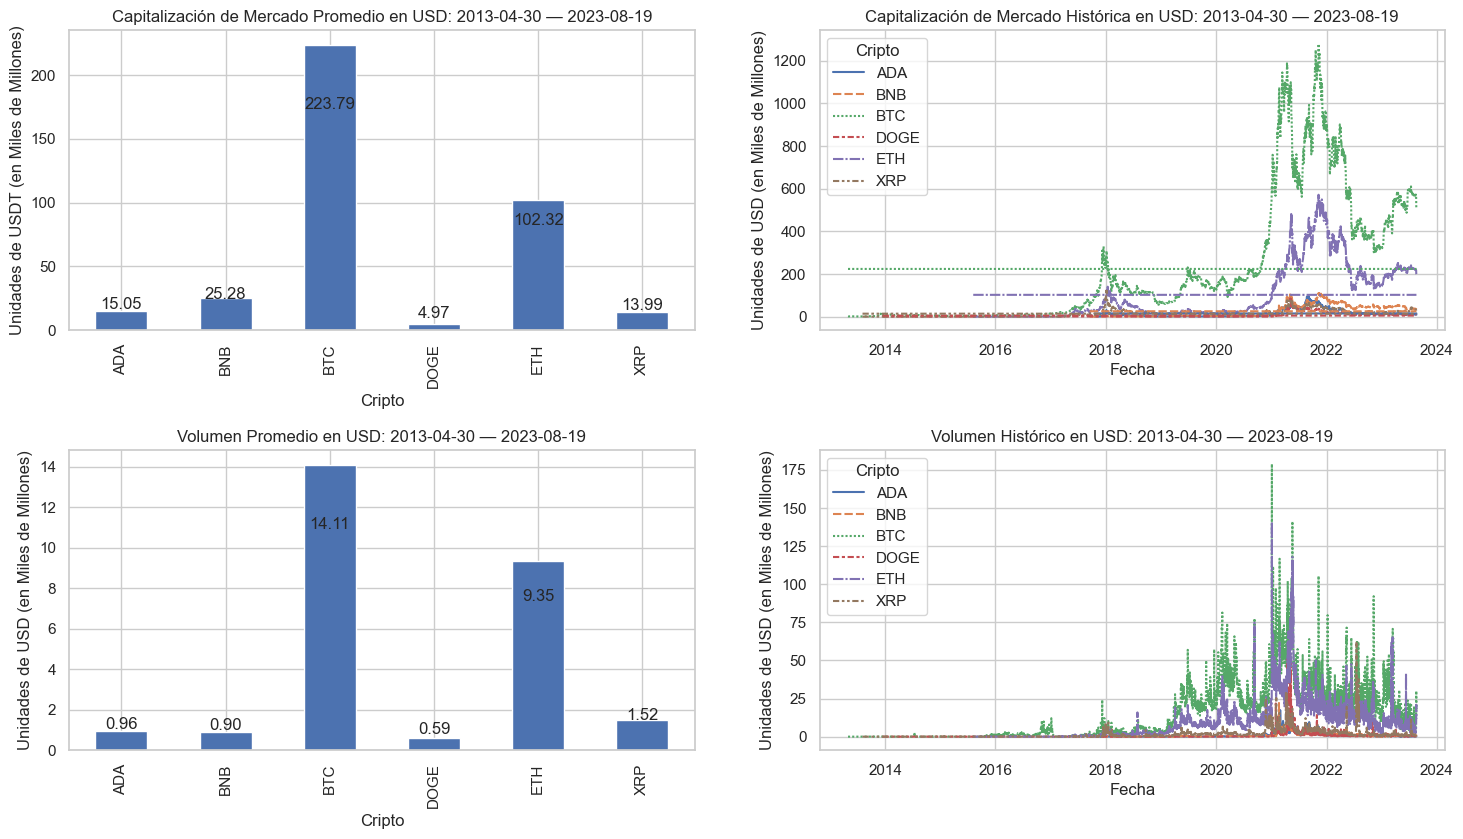

In [ ]:
fig = plt.figure()

plt.subplots_adjust(left=0.125,
                    bottom=0.1, 
                    right=0.9, 
                    top=0.9, 
                    wspace=0.2, 
                    hspace=0.4)

ax1 = fig.add_subplot(221)
ax2 = fig.add_subplot(222)
ax3 = fig.add_subplot(223)
ax4 = fig.add_subplot(224)

sd = mc_df.sort_values(by='Fecha').reset_index(drop=True).Fecha[0].strftime('%Y-%m-%d')
ed = mc_df.sort_values(by='Fecha').reset_index(drop=True).Fecha[-1:].item().strftime('%Y-%m-%d')

ax1.set_title(label = f'Capitalización de Mercado Promedio en USD: {sd} — {ed}')
ax1.set_ylabel('Unidades de USDT (en Miles de Millones)')

ax3.set_title(label=f'Volumen Promedio en USD: {sd} — {ed}')
ax3.set_ylabel(ylabel='Unidades de USD (en Miles de Millones)')

ax2.set_title(label=f'Capitalización de Mercado Histórica en USD: {sd} — {ed}')
ax2.set_ylabel(ylabel='Unidades de USD (en Miles de Millones)')

ax4.set_title(label=f'Volumen Histórico en USD: {sd} — {ed}')
ax4.set_ylabel(ylabel='Unidades de USD (en Miles de Millones)')

mc_df['Market_Cap_mM'] = mc_df.Market_Cap / 1000000000
usv_df['USD_Volumen_mM'] = usv_df.USD_Volumen / 1000000000

mc_criptos = mc_df.groupby('Cripto').last().sort_values(by='Market_Cap_mM',ascending=False).head(6).index.to_list()
mc_fisix = mc_df[mc_df.Cripto.isin(mc_criptos)]
usv_fisix = usv_df[usv_df.Cripto.isin(mc_criptos)]


mc_fisix.groupby('Cripto')['Market_Cap_mM'].mean().plot(kind='bar',ax=ax1)
sns.lineplot(mc_fisix.groupby(['Fecha','Cripto'])['Market_Cap_mM'].last().unstack(),ax=ax2) # .plot(kind='bar',ax=ax3)
mc_fisix = mc_fisix.merge(mc_fisix.groupby('Cripto')['Market_Cap_mM'].mean(), on='Cripto').rename(columns={ 'Market_Cap_mM_x': 'Market_Cap_mM', 'Market_Cap_mM_y':'Promedio'})
sns.lineplot(mc_fisix[mc_fisix.Cripto.isin(mc_criptos)].groupby(['Fecha','Cripto'])['Promedio'].last().unstack(),ax=ax2,legend=False)

usv_fisix.groupby('Cripto')['USD_Volumen_mM'].mean().plot(kind='bar',ax=ax3)
sns.lineplot(usv_fisix.groupby(['Fecha','Cripto'])['USD_Volumen_mM'].last().unstack(),ax=ax4) # .plot(kind='bar',ax=ax4)

planos = [ax1,ax3]
for plano in planos:
    for rect in plano.patches:
        # Get X and Y placement of label from rect.
        y_value = rect.get_height()
        x_value = rect.get_x() + rect.get_width() / 2

        # Number of points between bar and label. Change to your liking.
        space = 3
        # Vertical alignment for positive values
        va = 'bottom'

        # If value of bar is negative: Place label below bar
        if y_value < 0:
            # Invert space to place label below
            space *= -1
            # Vertically align label at top
            va = 'top'

        # Use Y value as label and format number with zero decimal place
        label = "{:.2f}".format(y_value)

        # Create annotation
        plano.annotate(
            label,                      # Use `label` as label
            (x_value, y_value - (y_value/4)),         # Place label at end of the bar
            xytext=(0, space),          # Vertically shift label by `space`
            textcoords="offset points", # Interpret `xytext` as offset in points
            ha='center',                # Horizontally center label
            va=va)                      # Vertically align label differently for
                                        # positive and negative values.

,Fecha,Cripto,Market_Cap,Market_Cap_mM,Promedio
0,2017-10-18,ADA,696021404.31,0.70,15.05
1,2017-10-19,ADA,695622018.26,0.70,15.05
2,2017-10-20,ADA,785580027.64,0.79,15.05
3,2017-10-21,ADA,741202123.88,0.74,15.05
4,2017-10-22,ADA,720669848.47,0.72,15.05
...,...,...,...,...,...
18161,2023-08-15,XRP,33526777989.72,33.53,13.99
18162,2023-08-16,XRP,32153506290.78,32.15,13.99
18163,2023-08-17,XRP,31112167895.25,31.11,13.99
18164,2023-08-18,XRP,26666217677.22,26.67,13.99
